In [1]:
!pip install -q -U "tensorflow-text==2.8.*"

In [2]:
!pip install -q tf-models-official==2.7.0

In [3]:
!pip install -q pydot

In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
train_df = pd.read_csv('../data/processed/train_data_processed.csv', index_col='id')
train_df = train_df[train_df['language'] == 'English'].reset_index(drop=True)
train_df.head()

,title,genre,description,year,processed_description,processed_description_string,language
0,Oscar et la dame rose,drama,Listening in to a conversation between his do...,2009,"['listen', 'convers', 'doctor', 'parent', '10-...",listen convers doctor parent 10-year-old oscar...,English
1,Cupid,thriller,A brother and sister with a past incestuous r...,1997,"['brother', 'sister', 'past', 'incestu', 'rela...",brother sister past incestu relationship curre...,English
2,"Young, Wild and Wonderful",adult,As the bus empties the students for their fie...,1980,"['bu', 'empti', 'student', 'field', 'trip', 'm...",bu empti student field trip museum natur histo...,English
3,The Secret Sin,drama,To help their unemployed father make ends mee...,1915,"['help', 'unemploy', 'father', 'make', 'end', ...",help unemploy father make end meet edith twin ...,English
4,The Unrecovered,drama,The film's title refers not only to the un-re...,2007,"['film', 'titl', 'refer', 'un-recov', 'bodi', ...",film titl refer un-recov bodi ground zero also...,English


In [7]:
def truncate_and_split_descriptions(df, batch_size=128):
    new_df_dict = {'genre':[], 'processed_description_string': []}
    for _, row in df.iterrows():
        processed_description = row['processed_description_string'].split()
        genre = row['genre']
        n = len(processed_description)
        for i in range(0, n, batch_size):
            new_df_dict['genre'].append(genre)
            new_df_dict['processed_description_string'].append(' '.join(processed_description[i:min(n, i+batch_size)]))
    new_df = pd.DataFrame(new_df_dict)
    return new_df    

In [8]:
# train_df = truncate_and_split_descriptions(train_df)

In [9]:
unique_genres = train_df['genre'].unique()
genre_encoding = dict([(unique_genres[i], i) for i in range(unique_genres.shape[0])])
train_df['genre'] = train_df['genre'].map(genre_encoding)
train_df = train_df.sample(frac=1, random_state=42)
train_df

,title,genre,description,year,processed_description,processed_description_string,language
50986,Extinct,12,Standing between NFSI and their takeover of t...,2010,"['stand', 'nfsi', 'takeov', 'free', 'republ', ...",stand nfsi takeov free republ outer barrier el...,English
25200,Don Carlo,14,"Based on Schiller's play of the same name, Do...",2012,"['base', 'schiller', 'play', 'name', 'carlo', ...",base schiller play name carlo written pari opé...,English
11658,What's Normal?,4,A young man is forced to leave his life of so...,2012,"['young', 'man', 'forc', 'leav', 'life', 'soli...",young man forc leav life solitud see world liv...,English
51085,"""Dr. Fad""",24,"Ken Hakuta, aka Dr. Fad, hosted this show for...",1990,"['ken', 'hakuta', 'aka', 'dr', 'fad', 'host', ...",ken hakuta aka dr fad host show bud scientist ...,English
48018,"""Kahiin To Hoga""",0,The about is Kashish and her four sisters. Su...,2003,"['kashish', 'four', 'sister', 'sujal', 'handso...",kashish four sister sujal handsom boy meet kas...,English
...,...,...,...,...,...,...,...
11284,M:I-3 Moviefone Unscripted: Tom Cruise/JJ Abr...,12,The film's main creative partners Cruise and ...,2006,"['film', 'main', 'creativ', 'partner', 'cruis'...",film main creativ partner cruis abram intervie...,English
44732,Babovresky 2,4,The story begins where the first film ended: ...,2014,"['stori', 'begin', 'first', 'film', 'end', ':'...",stori begin first film end : gossip-mong mr ho...,English
38158,Carl Andersens Underground der Liebe,3,This documentary offers a glimpse into Carl A...,2015,"['documentari', 'offer', 'glimps', 'carl', 'an...",documentari offer glimps carl andersen uncommo...,English
860,Triple Cross: Bin Laden's Spy in America,3,This is the true story of Egyptian spy Ali Mo...,2006,"['true', 'stori', 'egyptian', 'spi', 'ali', 'm...",true stori egyptian spi ali moham infiltr us i...,English


In [10]:
num_labels = train_df['genre'].nunique()
num_labels

27

In [11]:
x = train_df['processed_description_string'].values
y = pd.get_dummies(train_df['genre']).values

In [12]:
train_set_size = 49000
val_set_size = 2500
test_set_size = 2331

x_train = x[:train_set_size]
x_val = x[train_set_size:train_set_size+val_set_size]
x_test = x[train_set_size+val_set_size:train_set_size+val_set_size+test_set_size]

y_train = y[:train_set_size]
y_val = y[train_set_size:train_set_size+val_set_size]
y_test = y[train_set_size+val_set_size:train_set_size+val_set_size+test_set_size]

In [13]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [14]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

2022-11-28 14:42:40.785485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [15]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [16]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(128)(net)
    net = tf.keras.layers.Dropout(0.05)(net)
    net = tf.keras.layers.Dense(256)(net)
    net = tf.keras.layers.Dense(num_labels, activation='softmax')(net)
    return tf.keras.Model(text_input, net)

In [17]:
classifier_model = build_classifier_model()

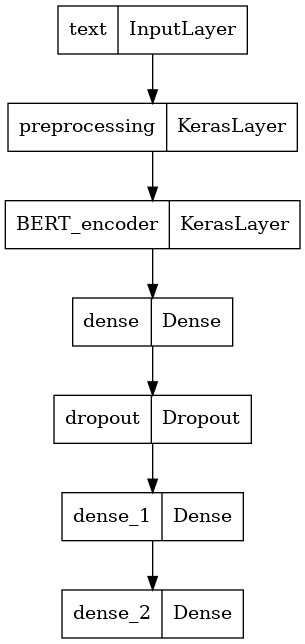

In [18]:
tf.keras.utils.plot_model(classifier_model, to_file='../models/{}.png'.format(bert_model_name))

In [19]:
epochs = 10

In [20]:
classifier_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [21]:
print(f'Training model with {tfhub_handle_encoder}')

my_callbacks  = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=0,
                              mode='auto')]
history = classifier_model.fit(x_train, y_train,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    callbacks=my_callbacks,
                    verbose=1
                   )

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/10
1532/1532 [==============================] - 53s 33ms/step - loss: 1.7654 - accuracy: 0.4884 - val_loss: 1.5398 - val_accuracy: 0.5572
Epoch 2/10
1532/1532 [==============================] - 50s 33ms/step - loss: 1.3830 - accuracy: 0.5954 - val_loss: 1.4725 - val_accuracy: 0.5560


In [22]:
loss, accuracy = classifier_model.evaluate(x_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

73/73 [==============================] - 2s 25ms/step - loss: 1.4969 - accuracy: 0.5543
Loss: 1.4969347715377808
Accuracy: 0.5542685389518738


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


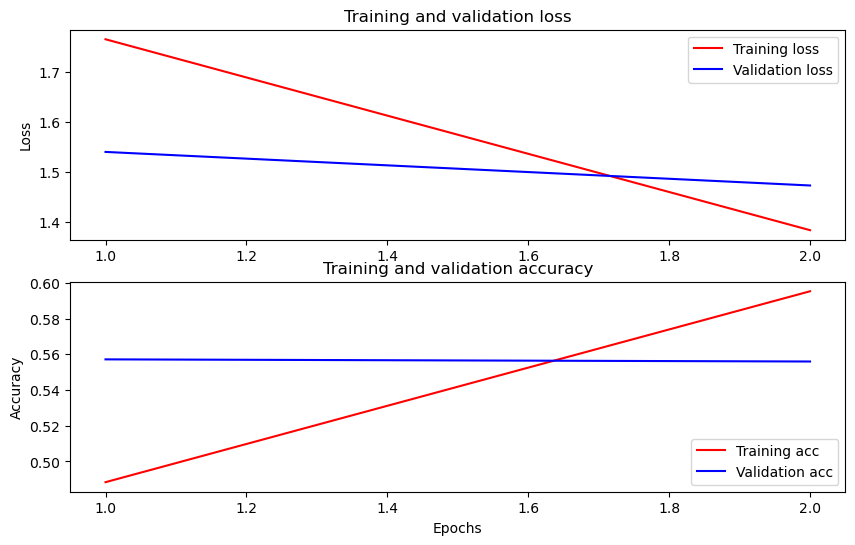

In [23]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [24]:
saved_model_path = '../models/{}'.format(bert_model_name)

classifier_model.save(saved_model_path, include_optimizer=False)

In [25]:
x_custom = np.array(['a hilarious tale'.lower()])

In [26]:
classifier_model.predict(x_custom)[0].argmax()

4

In [27]:
genre_encoding

{'drama': 0,
 'thriller': 1,
 'adult': 2,
 'documentary': 3,
 'comedy': 4,
 'crime': 5,
 'reality-tv': 6,
 'horror': 7,
 'sport': 8,
 'animation': 9,
 'action': 10,
 'fantasy': 11,
 'short': 12,
 'sci-fi': 13,
 'music': 14,
 'adventure': 15,
 'talk-show': 16,
 'western': 17,
 'family': 18,
 'mystery': 19,
 'history': 20,
 'news': 21,
 'biography': 22,
 'romance': 23,
 'game-show': 24,
 'musical': 25,
 'war': 26}

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score


def get_confusion_matrix(y_true, y_pred):
    fig, ax = plt.subplots(figsize=(10, 10))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax)
    plt.show()

    return None


def get_f1_score(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='macro')
    return f1

In [49]:
y_pred = classifier_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

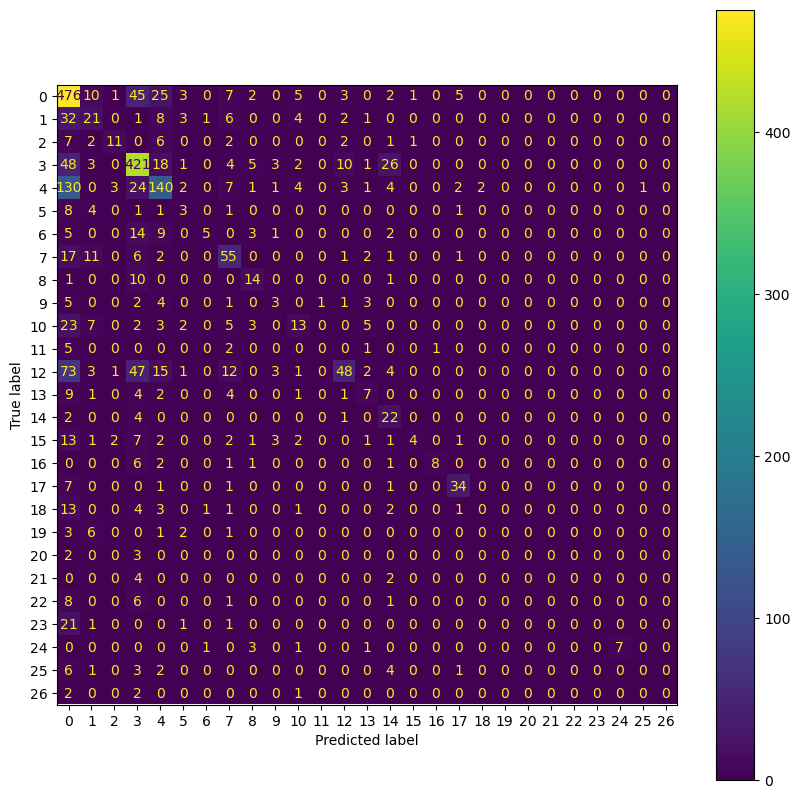

In [50]:
get_confusion_matrix(np.argmax(y_test, axis=1), y_pred)

In [51]:
get_f1_score(np.argmax(y_test, axis=1), y_pred)

0.28193335009622605